### Projeto de análise sentimentos de tweets


- Uso de transformers 
- Tratamento de dados  
- Naive Bayes  
- Linear SVC  


por Gabrielle Tenguan

In [138]:
# imports 
import pandas as pd 
import numpy as np

import transformers
import spacy 
import nltk 
import re
import seaborn as sns # graficos / matriz de confusao 
from tqdm import tqdm # import para visualização progress bar
tqdm.pandas()


In [139]:
from nltk.corpus import stopwords
# baixando pacote de linguagem em ingles, lg = large 
nlp = spacy.load('en_core_web_lg')
nltk.download('stopwords') # baixando stopwords para fazer o tratamento depois 


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielletenguan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [140]:
# carregando dataset 
df = pd.read_csv('Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [141]:
# verificando por valores nulos 
df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [142]:
# contagem de valores de sentimentos -> neg, neu, pos
df['sentiment'].value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [143]:
# tamanho do dataset
df.shape

(27481, 4)

In [144]:
# analisando padrao de texto com classificacao de sentimento 
df[['text', 'sentiment']]

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative
...,...,...
27476,wish we could come see u on Denver husband l...,negative
27477,I`ve wondered about rake to. The client has ...,negative
27478,Yay good for both of you. Enjoy the break - y...,positive
27479,But it was worth it ****.,positive


## Tratamento das reviews  


Algumas reviews possuem pontuação, letras maiúsculas, quebras de linha. Portanto, vamos limpar o dataset removendo esses caracteres.

In [145]:
# exemplo de texto com pontuacoes
df['text'][100]

'4am. And Im on the beach. Pretty'

In [146]:
# infos do dataset para confirmar tipo de cada dado 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [147]:
# funcao para remover pontuacoes
def clean_tweets(tweet): # def recebe uma tweet  do tipo object (string em pandas)
    ponc = re.findall(r'[^!.,?\s]+', str(tweet)) # usando re para remover pontuações das tweets
    
    return " ".join(ponc).lower() # retornando sem pontuação e transformando em caixa baixa 


In [148]:
df['cleaned-tweets'] = df['text'].apply(lambda x: clean_tweets(x)) # criando uma nova coluna do dataset com os tweets limpos 
df['cleaned-tweets'] = df['cleaned-tweets'].apply(lambda y: y.replace('<br />', '\n')) # substituindo quebras de linhas 

In [149]:
# verificando os 20 primeiros itens da nova coluna
df['cleaned-tweets'].head(20)

0                    i`d have responded if i were going
1            sooo sad i will miss you here in san diego
2                                my boss is bullying me
3                         what interview leave me alone
4     sons of **** why couldn`t they put them on the...
5     http://www dothebouncy com/smf - some shameles...
6     2am feedings for the baby are fun when he is a...
7                                            soooo high
8                                           both of you
9     journey wow u just became cooler hehe (is that...
10    as much as i love to be hopeful i reckon the c...
11    i really really like the song love story by ta...
12         my sharpie is running dangerously low on ink
13    i want to go to music tonight but i lost my voice
14                           test test from the lg env2
15                                 uh oh i am sunburned
16    s`ok trying to plot alternatives as we speak *...
17    i`ve been sick for the past few days and t

In [150]:
# verificando o texto teste novamente
print(df['cleaned-tweets'].loc[100])

4am and im on the beach pretty


## Removing stop words  

In [151]:
stop = stopwords.words('english')
# criando nova coluna no dataser que contem todos os tweets totalmente limpos 
df['tweets-all-cleaned'] = df['cleaned-tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) # usando apply para passar por cada linha 
df['tweets-all-cleaned'].head(6) # verificando as 6 primeiras linhas da nova coluna

0                                  i`d responded going
1                              sooo sad miss san diego
2                                        boss bullying
3                                interview leave alone
4       sons **** couldn`t put releases already bought
5    http://www dothebouncy com/smf - shameless plu...
Name: tweets-all-cleaned, dtype: object

## TFIDF

In [152]:
# separando em conjunto de treino e teste 
from sklearn.model_selection import train_test_split
X=df['tweets-all-cleaned'] # texto 
y=df['sentiment'] # label 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42) # tamanho de base de teste = 0.3 da base atual 

### Construindo pipelines para poder vectorizar a base de dados e treinar

In [153]:
from sklearn.pipeline import Pipeline # ajuda na automatização de processos 
from sklearn.feature_extraction.text import TfidfVectorizer # para converter o doc em uma matriz de features de tfidf 
from sklearn.naive_bayes import MultinomialNB # classificador para contagem de palavras para classificacao de texto, por exemplo 
from sklearn.svm import LinearSVC # criação do modelo 

In [154]:
# pipeline de naive bayes , conjunto de etapas 
text_clf_nb = Pipeline([('tfidf', TfidfVectorizer()), # pipeline permite a inserção de varios transformers para pre processar os dados 
                        ('clf', MultinomialNB()), # no caso estamos primeiro convertendo em uma matriz de features e depois chamando o classificador 
])

#modelo linear svc
text_clf_lsvc = Pipeline([('tfidf', TfidfVectorizer()), # vectorizando 
                          ('clf', LinearSVC())]) # chamando o modelo 

### Testando com Naive Bayes

In [155]:
# usando model.fit para carregar o model

model_nb = text_clf_nb.fit(X_train, y_train)

In [156]:
# testando previsoes 
predict_nb = text_clf_nb.predict(X_test)

<Axes: >

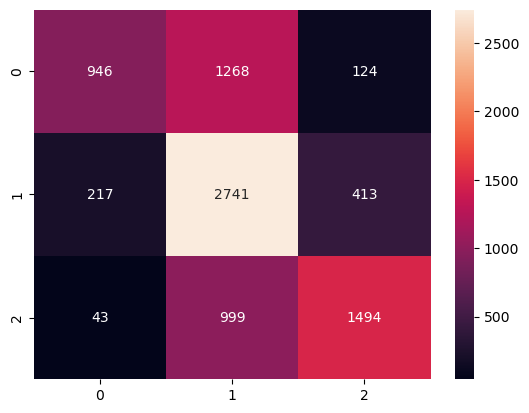

In [157]:
# importando confusion matrix para poder avaliar 
from sklearn.metrics import confusion_matrix
cf_nb = confusion_matrix(y_test, predict_nb)
sns.heatmap(cf_nb, annot=True, fmt='d')

In [158]:
# classification report 
from sklearn import metrics
print(metrics.classification_report(y_test, predict_nb))

              precision    recall  f1-score   support

    negative       0.78      0.40      0.53      2338
     neutral       0.55      0.81      0.65      3371
    positive       0.74      0.59      0.65      2536

    accuracy                           0.63      8245
   macro avg       0.69      0.60      0.61      8245
weighted avg       0.67      0.63      0.62      8245



Acurácia de 63%.  
Podemos observar que a precisão é menos para classificar tweets neutros - cerca de 55%

### Testando com o Linear SVM

In [159]:
# usando o model.fit para carregar o modelo
model_lsvc = text_clf_lsvc.fit(X_train, y_train)

In [160]:
# fazendo as previsoes 
predict_lsvc = text_clf_lsvc.predict(X_test)

<Axes: >

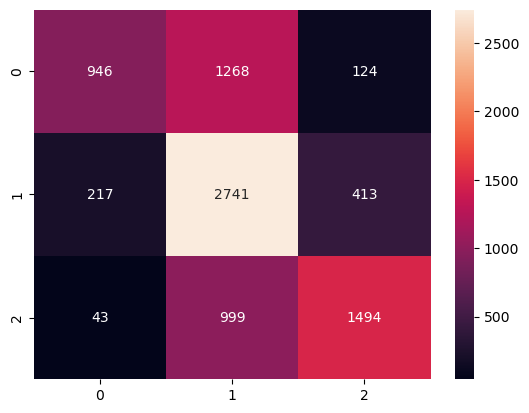

In [161]:
# confusion matrix 
cf_lsvc = confusion_matrix(y_test, predict_lsvc)
sns.heatmap(cf_nb, annot=True, fmt='d')


In [162]:
# classification report 
print(metrics.classification_report(y_test, predict_lsvc))

              precision    recall  f1-score   support

    negative       0.67      0.62      0.65      2338
     neutral       0.63      0.65      0.64      3371
    positive       0.71      0.73      0.72      2536

    accuracy                           0.67      8245
   macro avg       0.67      0.67      0.67      8245
weighted avg       0.67      0.67      0.67      8245



Acurácia de 67%.  
Podemos observar que, assim como no Naive Bayes, a precisão para identificar tweets neutros continua menor do que as outras categorias. Cerca de 63%

## Transformers 

In [163]:
from transformers import AutoTokenizer # transforma letras em numeros para que o computador possa entender 
from transformers import AutoModelForSequenceClassification # usado para carregar o modelo 
from scipy.special import softmax 

In [164]:
# carregando o modelo roBERTa

# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

/opt/anaconda3/envs/nlp_course/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you exp

In [165]:
# realizando a tokenizacao dos tweets com truncation=true e tamanho de 256 para garantir que todos tenham o mesmo tamanho 
df['tokenized-tweets'] = df['tweets-all-cleaned'].apply(lambda x: tokenizer(x, return_tensors='pt', truncation=True, max_length=256))

In [166]:
# infos da nova coluna 
df['tokenized-tweets'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 27481 entries, 0 to 27480
Series name: tokenized-tweets
Non-Null Count  Dtype 
--------------  ----- 
27481 non-null  object
dtypes: object(1)
memory usage: 214.8+ KB


In [167]:
# # dividindo em treino e teste 
X_t = df['tokenized-tweets'] 
y_t = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, train_size = 0.3, random_state = 42)

In [168]:
# print(transformers.__version__)

In [169]:
X_train[10955]

{'input_ids': tensor([[    0,   118, 12905,   119,   202,  3392, 17587,    36,    35, 23184,
           895, 11695,   939, 12905,   119,  2494,   741,  3961,  2596,    35,
           638,   334,   452,   205,   183,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])}

In [170]:
# rodando no roBERTa -> criando funcao para depois aplicar em todas as linhas do dataframe 
# primeiro vamos fazer o encoding do texto 
from operator import itemgetter # poder pegar a label (pos, neu, neg)
def run_roberta(text): # recebe o texto já tokenizado 
    output = model(**text) # retorna tensores
    scores = output[0][0].detach().numpy() #usa detach para transformar 
    scores = softmax(scores) # lista c probabilidades

    scores_dict = {
         'negative': scores[0],
         'neutral': scores[1],
         'positive': scores[2]
     }
    
    result = max(scores_dict.items(), key=itemgetter(1)) # pegando maior valor da probabilidade 
    return result[0] # retornando somente a classificacao 
    



In [171]:
# testando com um dos tweets do conjunto de treino 
run_roberta(df['tokenized-tweets'][10955])

'positive'

In [172]:
# printando a mesma linha para verificar se preveu corretamente
df.iloc[10955]

textID                                                       a77df4a95a
text                  I`m still up! Thank you all for praying (: AHA...
selected_text         I`m still up! Thank you all for praying (: AHA...
sentiment                                                      positive
cleaned-tweets        i`m still up thank you all for praying (: ahah...
tweets-all-cleaned    i`m still thank praying (: ahahaha i`m watchin...
tokenized-tweets                            [input_ids, attention_mask]
Name: 10955, dtype: object

In [173]:
# treinando com o conjunto de testes 

df['roberta-scores-train'] = X_train.progress_apply(lambda x: run_roberta(x))

100%|██████████| 8244/8244 [07:14<00:00, 18.99it/s]


In [174]:
# verificando a head das previsoes 
df['roberta-scores-train'].head()

0         NaN
1    negative
2         NaN
3         NaN
4         NaN
Name: roberta-scores-train, dtype: object

Verificando se os tamanhos do conjunto de previsões era o mesmo do conjunto de treino 

In [175]:
df['tokenized-tweets'].shape

(27481,)

In [176]:
X_train.shape

(8244,)

In [177]:
# verificando se tem valores nulos na nova coluna 
df['roberta-scores-train'].isnull().sum() 

19237

In [178]:
# para medir acurácia de treino, vamos pegar somente os nao nan 
df = df[df['roberta-scores-train'].notna()]

In [179]:
y_train.describe()

count        8244
unique          3
top       neutral
freq         3304
Name: sentiment, dtype: object

In [180]:
df['roberta-scores-train'].describe()

count        8244
unique          3
top       neutral
freq         3146
Name: roberta-scores-train, dtype: object

<Axes: >

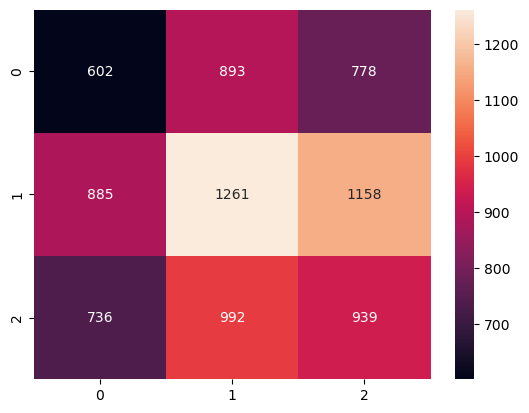

In [181]:
# criando matriz de confusao para visualizacao 
cf_roberta = confusion_matrix(y_train,df['roberta-scores-train'] )
sns.heatmap(cf_roberta, annot=True, fmt='d')

Observando a matriz, percebemos que ele as previsões de tweets negativos são piores. Enquanto na previsão de tweets neutros o modelo se saiu melhor.

In [182]:
# calculando acuracia do roberta 
print(metrics.classification_report(y_train, df['roberta-scores-train']))

              precision    recall  f1-score   support

    negative       0.27      0.26      0.27      2273
     neutral       0.40      0.38      0.39      3304
    positive       0.33      0.35      0.34      2667

    accuracy                           0.34      8244
   macro avg       0.33      0.33      0.33      8244
weighted avg       0.34      0.34      0.34      8244



Como já observado na matriz, a precisão de tweets negativos é muito baixa. Ao contrário do linear svc, o modelo foi capaz de prever melhor os tweets neutros, no conunto de treino.  
Em contra-partida, sua acurácia é baixa, o que é normal para uma base de treino.

In [183]:
X_test.shape

(19237,)

In [196]:
# testando com base de teste 

from tqdm import tqdm 
tqdm.pandas()
df['roberta-scores-test'] = X_test.progress_apply(lambda x: run_roberta(x))

100%|██████████| 19237/19237 [16:01<00:00, 20.01it/s]


In [197]:
df['roberta-scores-test'].head()

1588     positive
23879     neutral
6561      neutral
2602     negative
4003     positive
Name: roberta-scores-test, dtype: object

Verificando tamanho do novo conjunto 

In [198]:
df['roberta-scores-test'].shape

(19237,)

In [200]:
df['roberta-scores-test'].isnull().sum() 

0

In [199]:
df = df[df['roberta-scores-test'].notna()]

<Axes: >

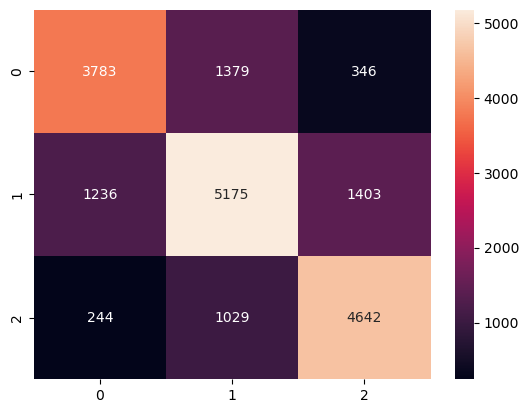

In [201]:
cf_roberta_test = confusion_matrix(y_test,df['roberta-scores-test'] )
sns.heatmap(cf_roberta_test, annot=True, fmt='d')

Observando a matriz, é possível concluir que o modelo roBERTa se saiu bem melhor que o Naive Bayes e o LinearSVC, com a diagonal principal - previsões feitas corretamente - possuem valores mais altos.

In [202]:
print(metrics.classification_report(y_test, df['roberta-scores-test']))

              precision    recall  f1-score   support

    negative       0.72      0.69      0.70      5508
     neutral       0.68      0.66      0.67      7814
    positive       0.73      0.78      0.75      5915

    accuracy                           0.71     19237
   macro avg       0.71      0.71      0.71     19237
weighted avg       0.71      0.71      0.71     19237



Ainda assim, a previsão de tweets neutros ainda tem a menor das precisões - 68%.  
Com acurácia de 71%, o modelo se saiu bem melhor que todos os outros. 
